# Decision tree classifier

In [237]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import PredefinedSplit
import umap

df = pd.read_csv('dataset-modified.csv', index_col=0)
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)
validation_df = pd.read_csv('validation.csv', index_col=0)

STATE = 12

## Split the features and the target column and normalize the data

In [238]:
# full dataset
X = df.drop('Class', axis=1)
y = df['Class']

# splits
X_train = train_df.drop('Class', axis=1)
y_train = train_df['Class']
X_validation = validation_df.drop('Class', axis=1)
y_validation = validation_df['Class']
X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

## Parametrai

### Grid Search

In [246]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 25),
    'max_features': [None, 'sqrt', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'splitter': ['best', 'random'],
}

X_combined = np.vstack((X_train, X_validation))
y_combined = np.hstack((y_train, y_validation))

test_fold = np.array([-1]*len(X_train) + [0]*len(X_validation))

ps = PredefinedSplit(test_fold)

def searchBestHyperparams(scoring = 'roc_auc'):    
    clf = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=STATE), 
        param_grid=params,
        scoring=scoring,
        n_jobs=1,
        cv=ps,
        verbose=1
    )

    clf.fit(X_combined, y_combined)

    best_params = clf.best_params_
    print("Best Parameters:", best_params)
    print("Best Score:", clf.best_score_)
    return best_params


best_params_auc = searchBestHyperparams('roc_auc')
best_params_accuracy = searchBestHyperparams('accuracy')

Fitting 1 folds for each of 1248 candidates, totalling 1248 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'splitter': 'best'}
Best Score: 0.9309398331137462
Fitting 1 folds for each of 1248 candidates, totalling 1248 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 0.8, 'splitter': 'random'}
Best Score: 0.8888888888888888


### max_depth

In [240]:
def plot_results(x, y1, y2, y1_label, y2_label, title, xlabel, ylabel):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    plt.plot(x, y1, 'r', label=y1_label)
    plt.plot(x, y2, 'b', label=y2_label)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

The optimal maximum depth is: 3


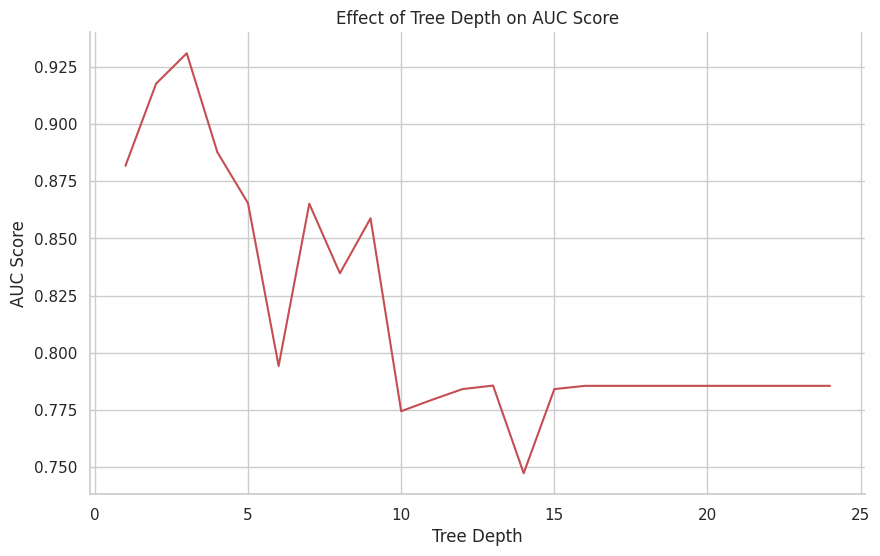

In [259]:
max_depths = np.arange(1, 25)
validation_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(
    max_depth=max_depth,
    random_state=STATE,
    max_features = best_params_auc['max_features'],
    splitter=best_params_auc['splitter'],
    criterion = best_params_auc['criterion'])

    dt.fit(X_train, y_train)

    validation_pred_proba = dt.predict_proba(X_validation)[:, 1]
    validation_auc = roc_auc_score(y_validation, validation_pred_proba)
    validation_results.append(validation_auc)

best_validation_auc = max(validation_results)
best_max_depth = max_depths[validation_results.index(best_validation_auc)]

print("The optimal maximum depth is:", best_max_depth)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(max_depths, validation_results, 'r', label="Validation AUC")

plt.title('Effect of Tree Depth on AUC Score')
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

The optimal maximum depth is: 3


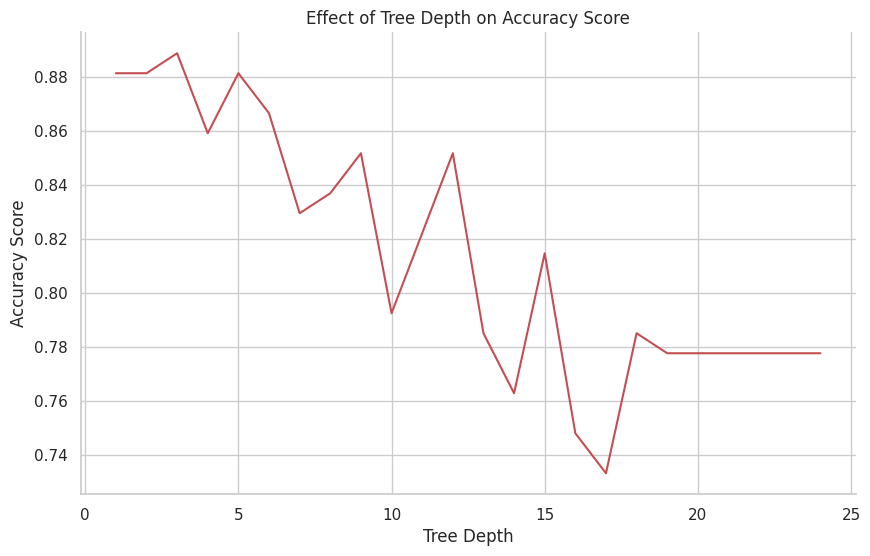

In [261]:
max_depths = np.arange(1, 25)
validation_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(
    max_depth=max_depth,
    random_state=STATE,
    max_features=best_params_accuracy["max_features"],
    splitter=best_params_accuracy["splitter"],
    criterion=best_params_accuracy["criterion"])

    dt.fit(X_train, y_train)

    validation_pred = dt.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    validation_results.append(validation_accuracy)

best_validation_accuracy = max(validation_results)

best_max_depth = max_depths[validation_results.index(best_validation_accuracy)]

print("The optimal maximum depth is:", best_max_depth)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(max_depths, validation_results, 'r', label="Validation Accuracy")

plt.title('Effect of Tree Depth on Accuracy Score')
plt.ylabel('Accuracy Score')
plt.xlabel('Tree Depth')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Trees

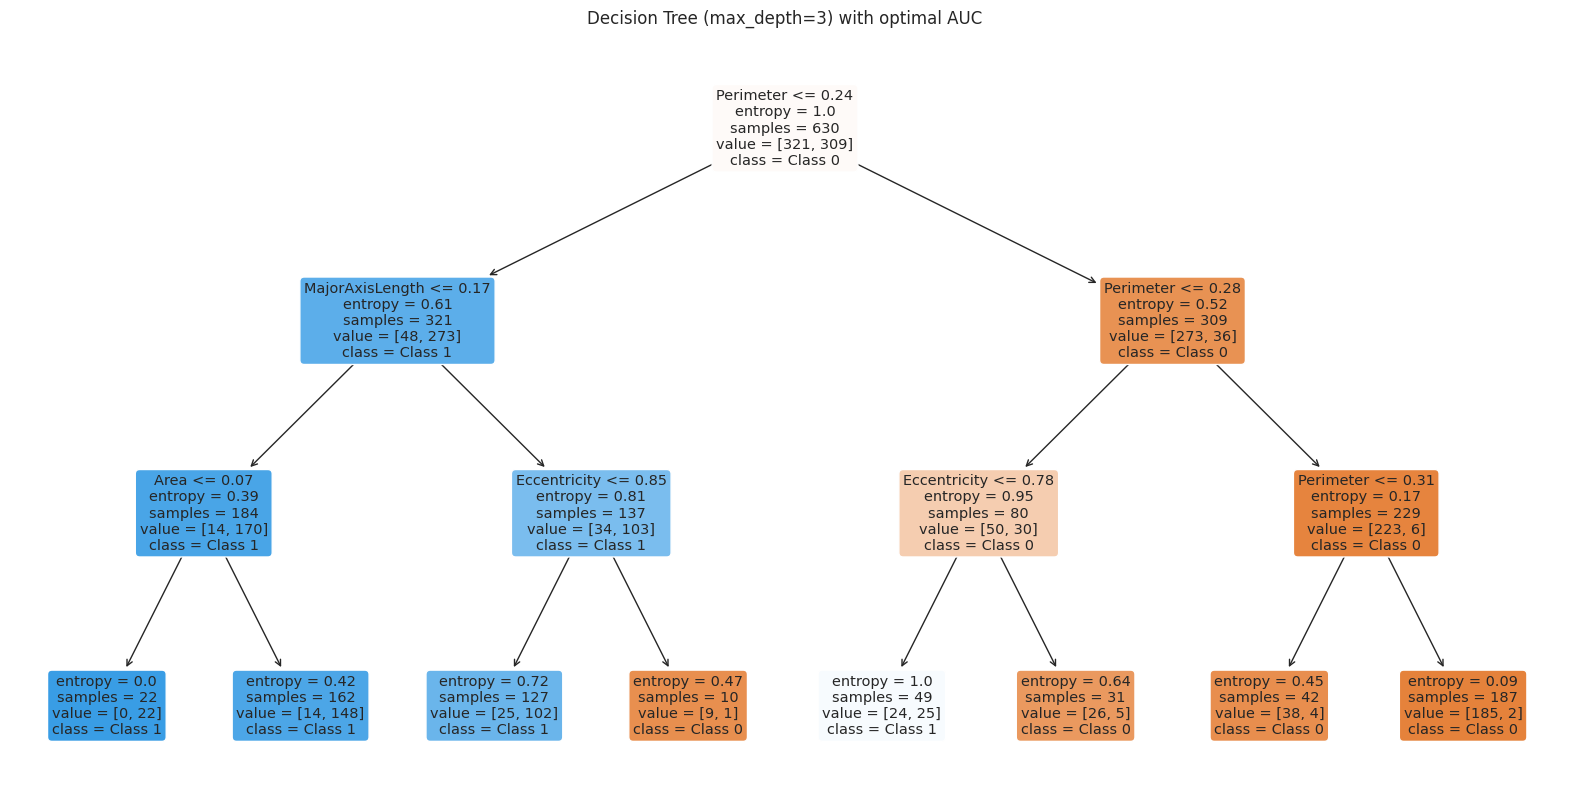

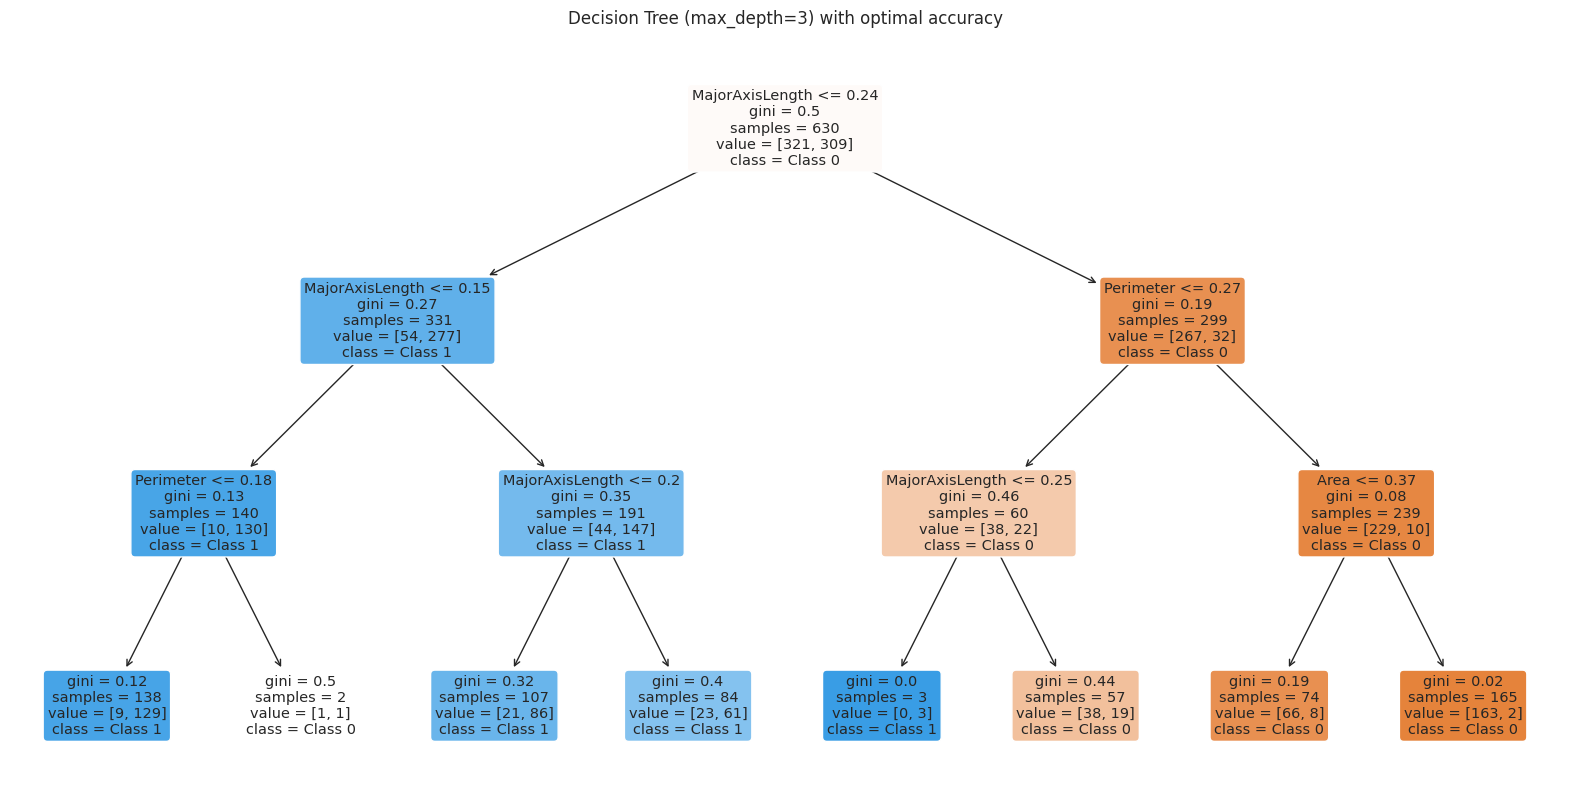

In [249]:
def plot_decision_tree(optimal_dt, title):
    optimal_dt.fit(X_train, y_train)
    plt.figure(figsize=(20,10))
    plot_tree(optimal_dt, 
            filled=True, 
            feature_names=X_train.columns, 
            class_names=['Class 0', 'Class 1'], 
            rounded=True, 
            proportion=False, 
            precision=2)
    plt.title(f'Decision Tree (max_depth={best_max_depth}) with optimal {title}')
    plt.show()

optimal_dt_auc = DecisionTreeClassifier(
    max_depth=best_max_depth,
    random_state=STATE,
    max_features=best_params_auc['max_features'],
    splitter=best_params_auc['splitter'],
    criterion=best_params_auc['criterion']
)

optimal_dt_accuracy = DecisionTreeClassifier(
    max_depth=best_max_depth,
    random_state=STATE,
    max_features=best_params_accuracy['max_features'],
    splitter=best_params_accuracy['splitter'],
    criterion=best_params_accuracy['criterion']
)

plot_decision_tree(optimal_dt_auc, "AUC")
plot_decision_tree(optimal_dt_accuracy, "accuracy")

## Stats

In [260]:

def get_result_stats(clf, X, y, pos_label="Kecimen"):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]

    conf_matrix = confusion_matrix(y, y_pred, labels=["Kecimen", "Besni"])
    acc = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_prob)
    precision = precision_score(y, y_pred, pos_label=pos_label)
    recall = recall_score(y, y_pred, pos_label=pos_label)
    f1 = f1_score(y, y_pred, pos_label=pos_label)

    return y_pred, acc, auc_score, precision, recall, f1, conf_matrix

def evaluate_decision_tree(X_train, y_train, X_test, y_test, depths, best_params, state):
    dtype = {
        "max_depth": int, "Accuracy": float, "AUC": float,
        "Precision": float, "Recall": float, "F1 Score": float
    }
    results_df = pd.DataFrame(columns=["max_depth", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]).astype(dtype)
    wrong_predictions = set()

    for depth in depths:
        clf = DecisionTreeClassifier(
            max_depth=depth,
            random_state=state,
            **best_params
        ).fit(X_train, y_train)

        y_pred, acc, auc_score, precision, recall, f1, conf_matrix = get_result_stats(clf, X_test, y_test)

        df_conf_matrix = pd.DataFrame(conf_matrix, index=["Actual Kecimen", "Actual Besni"],
                                      columns=["Predicted Kecimen", "Predicted Besni"])
        display(df_conf_matrix)

        temp_df = pd.DataFrame([[depth, acc, auc_score, precision, recall, f1]],
                               columns=["max_depth", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]).astype(dtype)
        results_df = pd.concat([results_df, temp_df])

        for i, (actual, predicted) in enumerate(zip(y_test, y_pred)):
            if actual != predicted:
                wrong_predictions.add((depth, i, actual, predicted))

    return results_df, wrong_predictions


depths = [2, 6, 10, 14]  

best_params_auc_test = {"max_features": best_params_auc['max_features'], "splitter": best_params_auc['splitter'],"criterion": best_params_auc['criterion']}
best_params_accuracy_test = {"max_features": best_params_accuracy['max_features'], "splitter": best_params_accuracy['splitter'],"criterion": best_params_accuracy['criterion']}
results_df, wrong_preds = evaluate_decision_tree(X_train, y_train, X_test, y_test, depths, best_params_auc_test, STATE)

results_df.to_latex(
    "dts-scores.tex", 
    float_format="%.3f", 
    caption="Calculated Metrics", 
    label="tab:dts-scores", 
    index=False, 
    escape=True, 
    bold_rows=True
)
display(results_df)


,Predicted Kecimen,Predicted Besni
Actual Kecimen,58,14
Actual Besni,9,54


,Predicted Kecimen,Predicted Besni
Actual Kecimen,56,16
Actual Besni,12,51


,Predicted Kecimen,Predicted Besni
Actual Kecimen,56,16
Actual Besni,11,52


,Predicted Kecimen,Predicted Besni
Actual Kecimen,57,15
Actual Besni,13,50


,max_depth,Accuracy,AUC,Precision,Recall,F1 Score
0,2,0.829630,0.881724,0.865672,0.805556,0.834532
0,6,0.792593,0.814153,0.823529,0.777778,0.800000
0,10,0.800000,0.811839,0.835821,0.777778,0.805755
0,14,0.792593,0.796737,0.814286,0.791667,0.802817


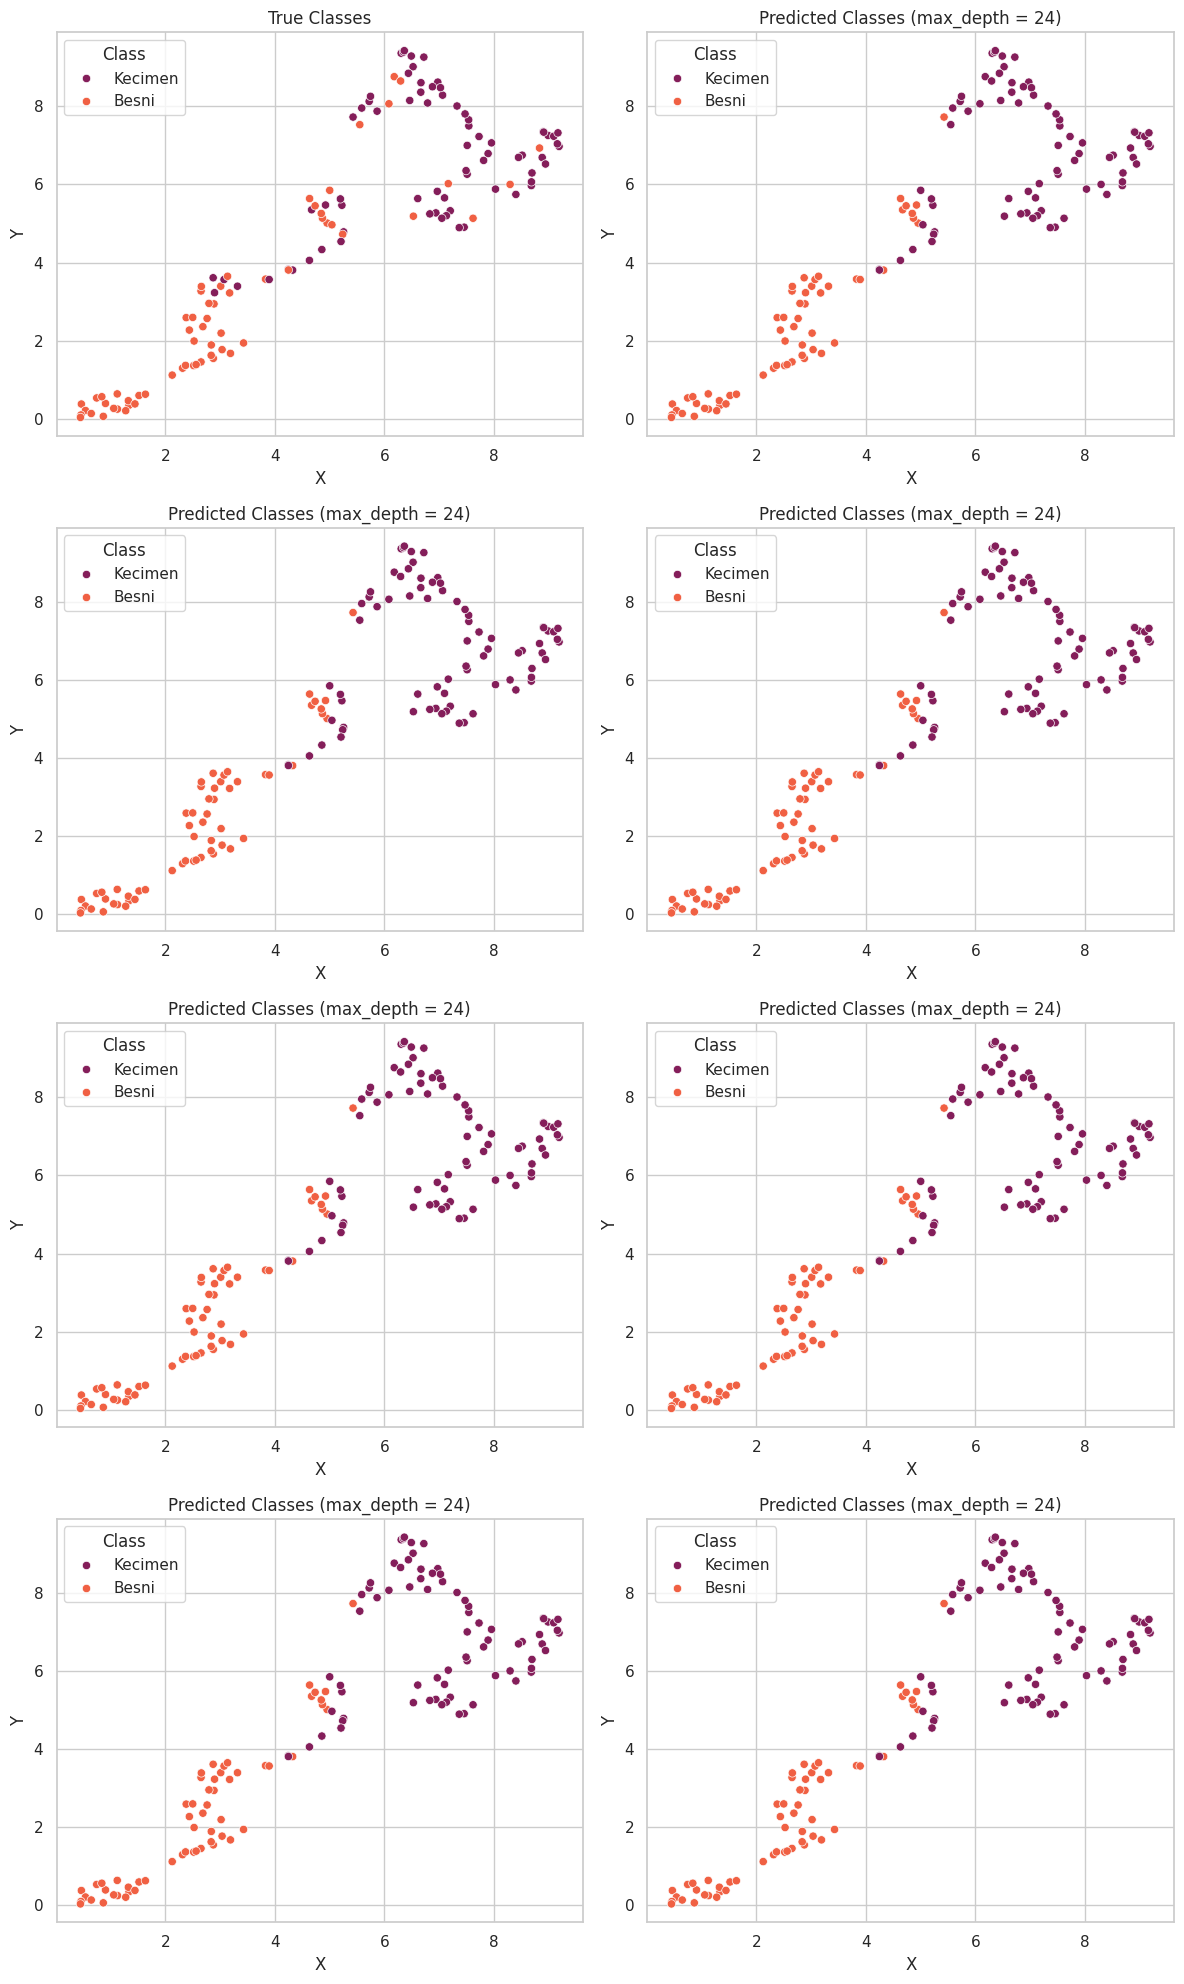

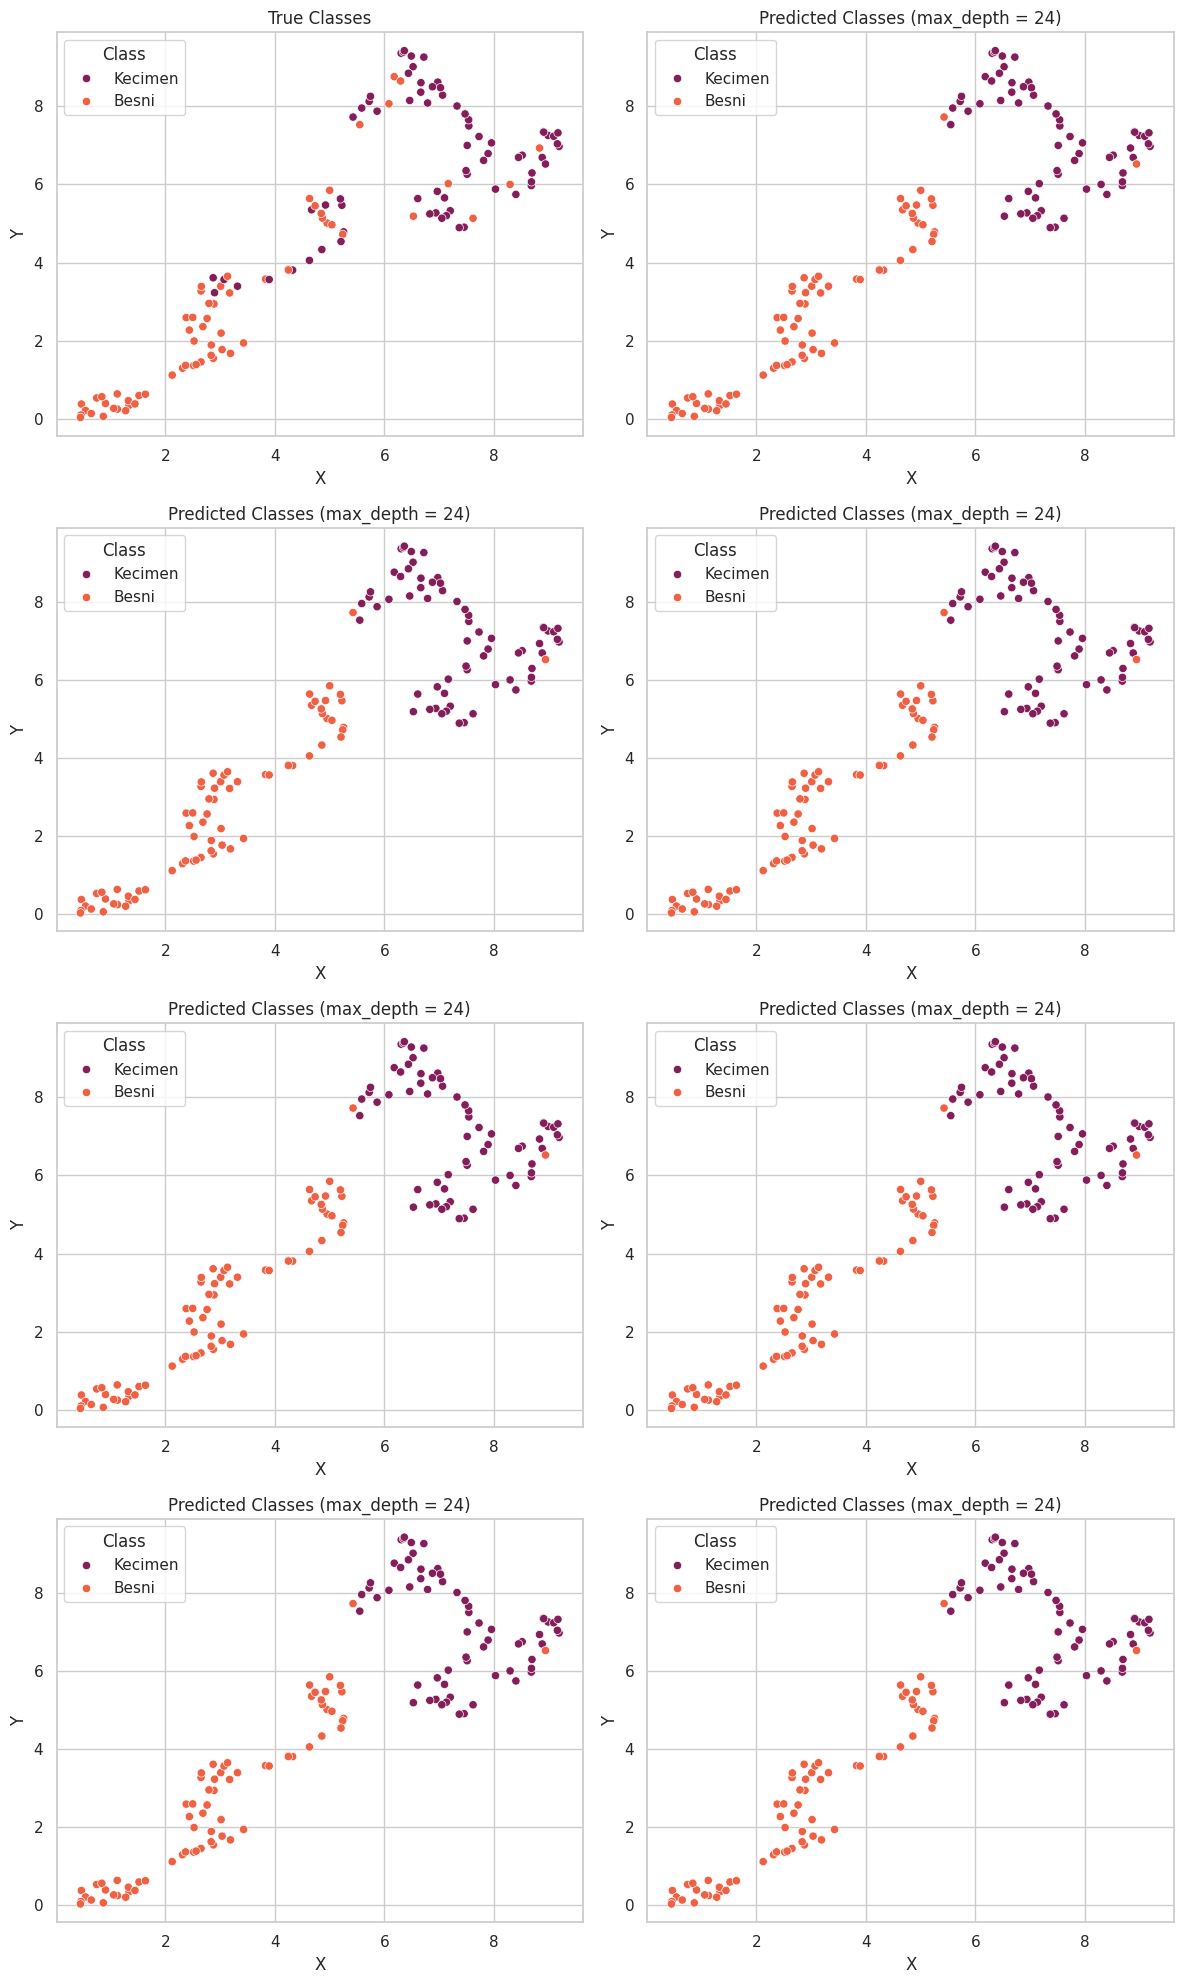

In [245]:
def plot_classes_scatterplot(dt, ax):
    dts = dt.fit(X_train, y_train)
    y_test_pred = dts.predict(X_test)

    umap_reducer = umap.UMAP(n_neighbors=20, random_state=42, n_jobs=1)
    X_test_umap = umap_reducer.fit_transform(X_test)

    df_pred = pd.DataFrame(data={'UMAP1': X_test_umap[:, 0], 'UMAP2': X_test_umap[:, 1], 'Class': y_test_pred})

    sns.scatterplot(data=df_pred, x='UMAP1', y='UMAP2', hue='Class', palette="rocket", ax=ax)
    ax.set_title(f'Predicted Classes (max_depth = {max_depth})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(title='Class', loc='upper left')


def render_plot(dt):
    fig, axs = plt.subplots(4, 2, figsize=(12, 20))
    axs = axs.flatten()

    umap_reducer = umap.UMAP(n_neighbors=20, random_state=42, n_jobs=1)
    X_test_umap = umap_reducer.fit_transform(X_test)

    df_true = pd.DataFrame(data={'UMAP1': X_test_umap[:, 0], 'UMAP2': X_test_umap[:, 1], 'Class': y_test})
    sns.scatterplot(data=df_true, x='UMAP1', y='UMAP2', hue='Class', palette="rocket", ax=axs[0])
    axs[0].set_title('True Classes')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].legend(title='Class', loc='upper left')

    for n, ax in zip([1, 2, 3, 4, 5, 6, 7, 8], axs[1:]):
        plot_classes_scatterplot(dt, ax=ax)

    plt.tight_layout()
    plt.show()


optimal_dt_auc = DecisionTreeClassifier(
    max_depth=best_params_auc['max_depth'],
    random_state=STATE,
    max_features=best_params_auc['max_features'],
    splitter=best_params_auc['splitter'],
    criterion=best_params_auc['criterion']
)

optimal_dt_accuracy = DecisionTreeClassifier(
    max_depth=best_params_accuracy['max_depth'],
    random_state=STATE,
    max_features=best_params_accuracy['max_features'],
    splitter=best_params_accuracy['splitter'],
    criterion=best_params_accuracy['criterion']
)

render_plot(optimal_dt_auc)
render_plot(optimal_dt_accuracy)